In [1]:
import os
import json
import warnings
import re
import pandas as pd

from sys import getsizeof

import nltk # version 3.2.5
from nltk.corpus import stopwords
import emoji # version 0.4.5
from profanity import profanity # version 1.1
from wordcloud import WordCloud 
from collections import Counter
from toolz import valfilter

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
sns.set(style="whitegrid")
sns.set(font_scale=1.2)
%matplotlib inline

warnings.filterwarnings('ignore')
nltk.download('stopwords');

[nltk_data] Downloading package stopwords to /Users/lia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

# Data Analysis

In [61]:
NEG_DATA_PATH = '../data/twitter-datasets/train_neg_full.txt'
POS_DATA_PATH = '../data/twitter-datasets/train_pos_full.txt'

In [62]:
def read_json(path):
    """
    Reads data from path and puts in a list of strings

    Parameters
    ----------
    path : string with the file path

    Returns
    -------
    list of strings

    """
    lines = []
    with open(path, "r") as doc:
        for line in doc:
            lines.append(line)
    return lines

In [63]:
raw_pos = pd.DataFrame(read_json(POS_DATA_PATH), columns=['raw_tweet'])
raw_pos['score'] = 1
raw_neg = pd.DataFrame(read_json(NEG_DATA_PATH), columns=['raw_tweet'])
raw_neg['score'] = -1
raw_tweets = pd.concat([raw_pos, raw_neg], axis=0)

In [64]:
print('Dataframe size: {size}MB \nDataframe shape: {shape}'
      .format(size=round(getsizeof(raw_tweets)/10**6, 2),
             shape=raw_tweets.shape))

Dataframe size: 374.92MB 
Dataframe shape: (2500000, 2)


In [74]:
print('# Positive: {pos}'.format(pos=(raw_tweets['score']==1).sum()))
print('# Negative: {neg}'.format(neg=(raw_tweets['score']==-1).sum()))

# Positive: 1250000
# Negative: 1250000


In [75]:
def preprocessing_text(series):
    """
    Clean elements of a series of string

    Parameters
    ----------
    series : series of strings

    Returns
    -------
    series with treated text

    """
    series = series.str.lower()

    series = series.str.replace('<user>', '')
    series = series.str.replace('<url>', '')
    
    series = series.str.replace('n\'t', 'not')
    series = series.str.replace('i\'m', 'i am')
    series = series.str.replace('\'re', ' are')
    series = series.str.replace('it\'s', 'it is')
    series = series.str.replace('that\'s', 'that is')
    series = series.str.replace('\'ll', ' will')
    series = series.str.replace('\'l', ' will')
    series = series.str.replace('\'ve', ' have')
    series = series.str.replace('\'d', ' would')
    series = series.str.replace('he\'s', 'he is')
    series = series.str.replace('she\'s', 'she is')
    series = series.str.replace('what\'s', 'what is')
    series = series.str.replace('who\'s', 'who is')
    series = series.str.replace('could\'ve', 'could have')
    series = series.str.replace('\'s', '')
    
    regex_letters = re.compile(r"[^\w\d\s]")
    series = series.str.replace(regex_letters, '')
    
    return series

In [76]:
def remove_stop_words(series):
    """
    Remove stop words from a series of string

    Parameters
    ----------
    series : series of strings

    Returns
    -------
    series without stop words

    """
    regex_stop = pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    series = series.str.replace(regex_stop, '')
    
    return series

In [77]:
def features_eng(df):
    """
    Apply feature enginneing

    Parameters
    ----------
    dataframe : dataframe with columns of treated_text and clean_text

    Returns
    -------
    dataframe with feature enginnering (basic counts)

    """
    df['count_user'] = df['raw_tweet'].str.count('<user>')
    df['count_url'] = df['raw_tweet'].str.count('<url>')
    df['count_!'] = df['raw_tweet'].str.count('!')
    df['count_?'] = df['raw_tweet'].str.count('\?')
    df['count_#'] = df['raw_tweet'].str.count('#')
#     df['count_tsk'] = df['raw_tweet'].str.count('tsk')
    df['count_<3'] = df['raw_tweet'].str.count('<3')
    df['count_lol'] = df['raw_tweet'].str.count('lol')
    df['count_words'] = df['clean_tweet'].str.split().str.len()
    
    # emojis
    emojis_list = map(lambda x: 
                      ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
    regex_emojis = re.compile('|'.join(re.escape(p) 
                                       for p in emojis_list))
#     df['count_emojis'] = df['raw_tweet'].str.count(regex_emojis)
    
    # bad words
    regex_bad = re.compile('|'.join(re.escape(p) 
                                       for p in profanity.get_words()))
    
    df['count_profanity'] = df['clean_tweet'].str.count(regex_bad)
                            
    return df

In [78]:
raw_tweets['treated_tweet'] = preprocessing_text(raw_tweets['raw_tweet'])
raw_tweets['clean_tweet'] = remove_stop_words(raw_tweets['treated_tweet'])
raw_tweets = features_eng(raw_tweets)

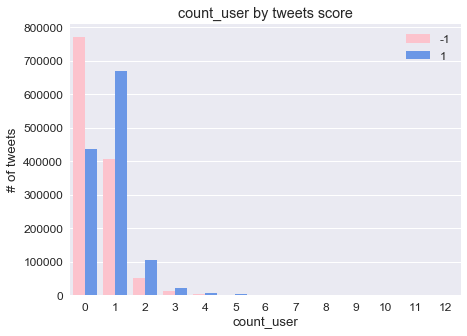

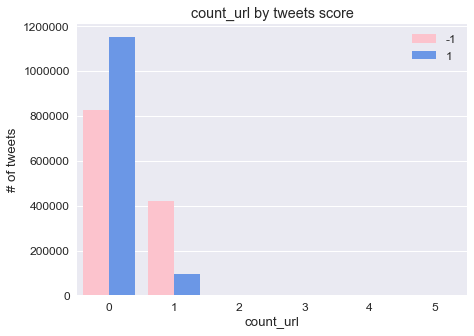

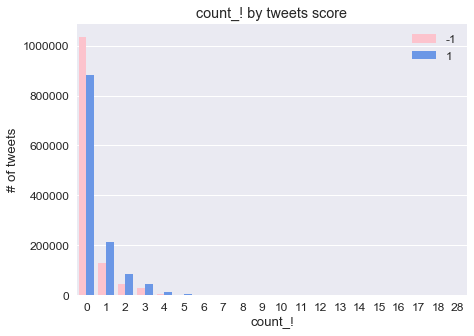

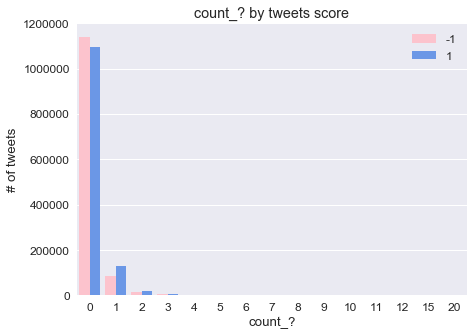

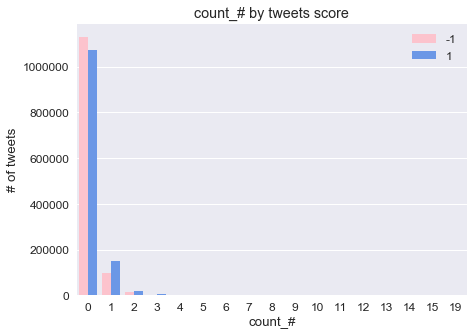

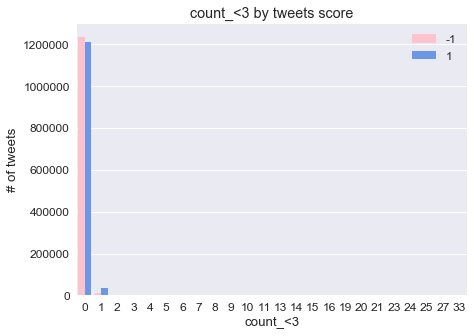

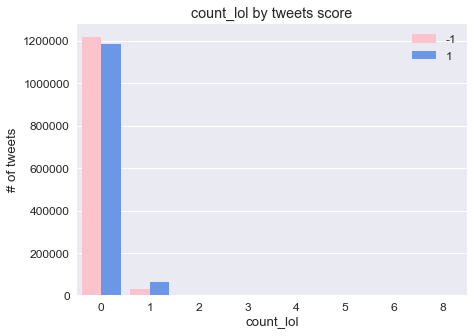

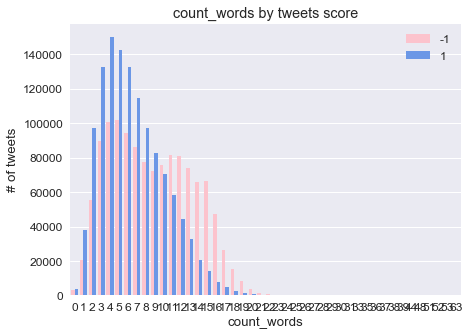

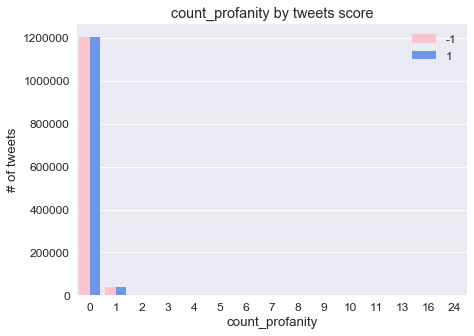

In [193]:
numeric_features = ['count_user', 'count_url', 'count_!', 'count_?',
                   'count_#', 'count_<3', 'count_lol', 'count_words', 'count_profanity']

for c in numeric_features:
    g = (pd.DataFrame(raw_tweets.groupby([c, 'score'])
                      .size())
         .reset_index())
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.barplot(x=c, y=0, hue='score', data=g, 
                     saturation=0.9, palette=['pink', 'cornflowerblue'])
    ax.set_title('{} by tweets score'.format(c))
    ax.set_ylabel('# of tweets')
    ax.legend(loc='upper right')
    ax;

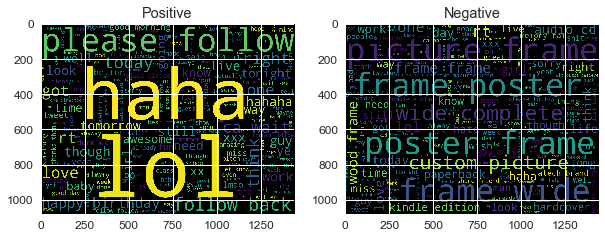

In [204]:
f, ax = plt.subplots(1, 2, figsize=(10, 10))

pos = list(raw_tweets[raw_tweets.score==1]['clean_tweet'])
neg = list(raw_tweets[raw_tweets.score==-1]['clean_tweet'])

cloud = WordCloud(width=1440, height=1080).generate(' '.join(pos));
ax[0].imshow(cloud);
ax[0].set_title('Positive')
cloud = WordCloud(width=1440, height=1080).generate(' '.join(neg));
ax[1].imshow(cloud);
ax[1].set_title('Negative')
ax;

# Vocabulary.txt

In [244]:
all_words = filter(lambda x:
                   x!='', 
                   ' '.join(raw_tweets['clean_tweet']).split(' '))
words_to_save = list(valfilter(lambda x: x>5,
                               dict(Counter(all_words))).keys())

In [246]:
vocabulary = open('vocab.txt', 'w')
for item in words_to_save:
    vocabulary.write("%s\n" % item)

In [ ]:
# then I runned 
# cut_vocab.sh
# python3 pickle_vocab.py
# python3 cooc.py